In [2]:
import pandas as pd
from PIL import Image
import os
from torchvision import transforms
import torch 
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None, img_path_col = 'image_path', text_desc_col='label'):
        self.data = pd.read_csv(csv_file)
        self.img_path_col = img_path_col
        self.text_desc_col = text_desc_col
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[self.img_path_col].iloc[idx]
        image = Image.open(img_path).convert("RGB")
        description = self.data[self.text_desc_col].iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, description

In [33]:
batch_size = 16
num_epochs = 100
learning_rate = 1e-5

In [34]:
from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(csv_file='data_balanced/train/data_train.csv', transform=image_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
log_loss = {}
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(num_epochs):
    for images, descriptions in train_dataloader:
        inputs = processor(text=descriptions, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device) # Tokenize txt
        images = images.to(device)
        # Forward pass
        outputs = model(pixel_values=images, input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # Calculate contrastive loss
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # Create labels for contrastive loss using cross-entropy
        labels = torch.arange(len(images)).to(device)  
        loss_img = torch.nn.functional.cross_entropy(logits_per_image, labels)
        loss_txt = torch.nn.functional.cross_entropy(logits_per_text, labels)
        loss = (loss_img + loss_txt) / 2 # avg loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_loss[epoch] = loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, loss_img: {loss_img}, loss_txt: {loss_txt}")


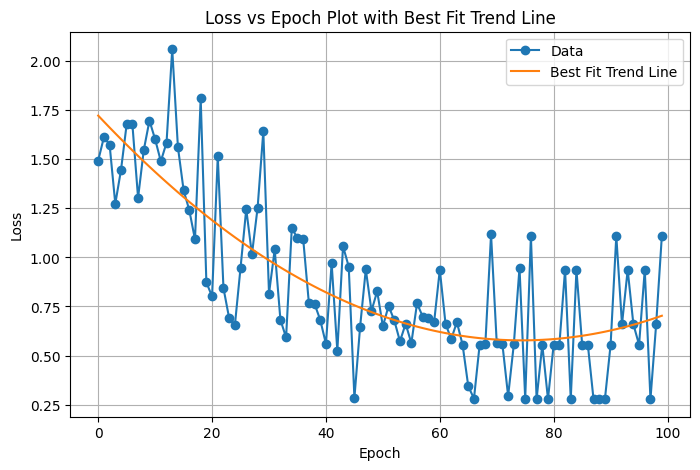

In [44]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(log_loss.keys())
losses = list(log_loss.values())

epochs_np = np.array(epochs)
losses_np = np.array(losses)

fit = np.polyfit(epochs_np, losses_np, 2) # Fit a polynomial of degree 2 to the data
x_fit = np.linspace(min(epochs_np), max(epochs_np), 100) # Generate x values for the fitted polynomial line
y_fit = np.polyval(fit, x_fit) # Calculate the fitted polynomial y values

plt.figure(figsize=(8, 5))  
plt.plot(epochs, losses, marker='o', linestyle='-', label='Data')  
plt.plot(x_fit, y_fit, label='Best Fit Trend Line')  # polynomial curve
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Plot with Best Fit Trend Line')
plt.grid(True)  # Add grid lines for better readability
plt.legend()  # Add a legend to identify the curves

plt.show()

In [76]:
test_df = pd.read_csv('data_balanced/test/data_test.csv')

classes = ['Erythroleukoplakia', 'Leukoplakia', 'Tumor', 'Ulcer']
test_image_paths = test_df['image_path'].to_list()

def predict_image_descriptions(image_paths, text_descriptions):
    results = []
    text_inputs = processor(text=text_descriptions, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device) # Process the text descriptions 

    with torch.no_grad():  # Disable gradient calculation for inference
        for img_path in image_paths:
            image = Image.open(img_path).convert("RGB")
            image_inputs = processor(images=image, return_tensors="pt").to(device)
            
            outputs = model(**image_inputs, input_ids=text_inputs['input_ids'], attention_mask=text_inputs['attention_mask'])
            logits_per_image = outputs.logits_per_image
            
            predicted_index = logits_per_image.argmax().item()
            results.append((img_path, predicted_index))
    return results

predictions = predict_image_descriptions(test_image_paths, classes)

preds = []
for img_path, predicted_index in predictions:
    preds.append(classes[predicted_index])

In [78]:
y_true = test_df['label'].to_list()
y_pred = preds

len(y_true), len(y_pred)

(137, 137)

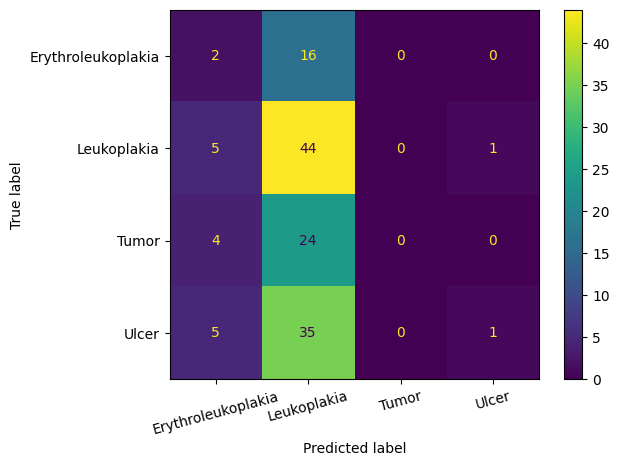

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes )

disp.plot(xticks_rotation=15)